In [1]:
# CARGAR LIBRERIAS

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
#from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# CARGAR BASE DE DATOS

df = pd.read_csv('../BBDD/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
# BORRAR COLUMNA ID

df.drop(columns='id', inplace=True)

In [5]:
# COMPROBAR NANS Y PORCENTAJE

print(df.isnull().sum())
print('')
print(df.isnull().sum() / len(df) * 100)

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64


In [ ]:
# COMPROBAR DUPLICADOS

df.duplicated().sum()

In [6]:
# SUSTITUIR EN COLUMNA 'GENDER' FEMALE POR 0 Y MALE POR 1

df.loc[df['gender'] == 'Female', 'gender'] = 0
df.loc[df['gender'] == 'Male', 'gender'] = 1

In [7]:
# SUSTITUIR EN COLUMNA 'EVER_MARRIED' NO POR 0 Y YES POR 1

df.loc[df['ever_married'] == 'No', 'ever_married'] = 0
df.loc[df['ever_married'] == 'Yes', 'ever_married'] = 1

In [8]:
# SUSTITUIR EN COLUMNA 'RESIDENCE TYPE' RURAL POR 0 Y URBAN POR 1

df.loc[df['Residence_type'] == 'Rural', 'Residence_type'] = 0
df.loc[df['Residence_type'] == 'Urban', 'Residence_type'] = 1

In [9]:
# COMPROBAR CON UNA MASCARA SI HAY ALGUNA FILA CON GENDER 'OTHER'

df[df['gender'] == 'Other']

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,0,Private,0,143.33,22.4,formerly smoked,0


In [10]:
# BORRAR FILA CON GENDER 'OTHER'

df.drop(index= 3116, inplace=True)

In [11]:
# RESETEAR LOS VALORES DEL INDICE

df.reset_index(drop = True, inplace = True)

In [12]:
# VALORES UNICOS DE ALGUNAS COLUMNAS CATEGORICAS

print('Valores unicos de work_type: ', df['work_type'].unique())
print(' ')
print('Valores unicos de smoking_status: ', df['smoking_status'].unique())

Valores unicos de work_type:  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
 
Valores unicos de smoking_status:  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [13]:
# DESGLOSAR EN DISTINTAS COLUMNAS 'WORK TYPE' Y 'SMOKING STATUS'

df2 = pd.get_dummies(data=df, columns=['work_type', 'smoking_status'])

In [14]:
# CAMBIAR TIPOS EN COLUMNAS

df2 = df2.astype({
    'gender': 'int64',
    'age': 'int64',
    'ever_married': 'int64',
    'Residence_type':'int64'
})

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          5109 non-null   int64  
 1   age                             5109 non-null   int64  
 2   hypertension                    5109 non-null   int64  
 3   heart_disease                   5109 non-null   int64  
 4   ever_married                    5109 non-null   int64  
 5   Residence_type                  5109 non-null   int64  
 6   avg_glucose_level               5109 non-null   float64
 7   bmi                             4908 non-null   float64
 8   stroke                          5109 non-null   int64  
 9   work_type_Govt_job              5109 non-null   uint8  
 10  work_type_Never_worked          5109 non-null   uint8  
 11  work_type_Private               5109 non-null   uint8  
 12  work_type_Self-employed         51

In [ ]:
# DIVIDIR EN TRAIN Y TEST

X = df2.drop('stroke', axis=1)
y = df2['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# TAMAÑOS DE SPLITS Y TOTAL DE 1(STROKE) EN Y_TRAIN Y EN Y_TEST

print('Tamaños')
print('-------')
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)
print(' ')
print('Total de stroke en splits')
print('-------------------------')
print('y_train:', y_train[y_train == 1].count())
print('y_test:', y_test[y_test == 1].count())

In [ ]:
df2.columns

In [ ]:
# IMPUTAR MISSINGS MEDIANTE KNN

imputer = KNNImputer(n_neighbors=5)

imputer.fit(df2[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']])

df2[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']] = imputer.transform(df2[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']])

In [35]:
# COMPROBAR QUE NO HAY MISSINGS

df2.isnull().sum()

gender                            0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
Residence_type                    0
avg_glucose_level                 0
bmi                               0
stroke                            0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [37]:
# ESTADISTICOS DEL DATAFRAME

round(df2.describe(), 2)

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
count,5109.00,5109.00,5109.0,5109.00,5109.00,5109.00,5109.00,5109.00,5109.00,5109.00,5109.00,5109.00,5109.00,5109.00,5109.00,5109.00,5109.00,5109.00
mean,0.41,43.22,0.1,0.05,0.66,0.51,106.14,28.71,0.05,0.13,0.00,0.57,0.16,0.13,0.30,0.17,0.37,0.15
std,0.49,22.63,0.3,0.23,0.47,0.50,45.29,7.07,0.22,0.33,0.07,0.49,0.37,0.34,0.46,0.38,0.48,0.36
min,0.00,0.00,0.0,0.00,0.00,0.00,55.12,10.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,25.00,0.0,0.00,0.00,0.00,77.24,23.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,45.00,0.0,0.00,1.00,1.00,91.88,28.20,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,61.00,0.0,0.00,1.00,1.00,114.09,32.80,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00
max,1.00,82.00,1.0,1.00,1.00,1.00,271.74,45.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


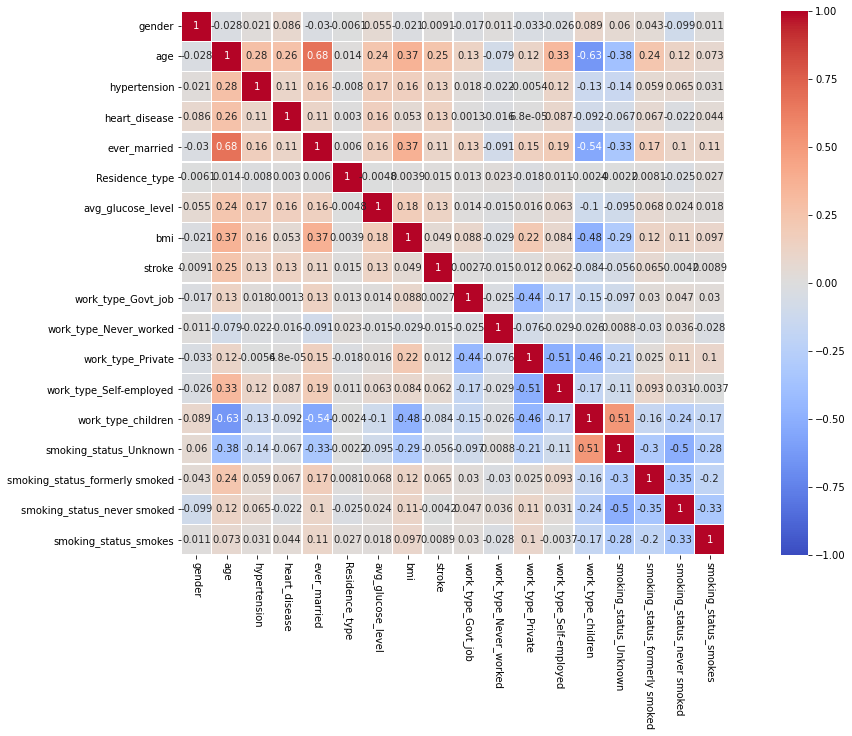

In [38]:
plt.figure(figsize=(20,10))
sns.heatmap(df2.corr(),
           vmin = -1,
           vmax = 1,
           cmap=sns.color_palette("coolwarm", as_cmap=True),
           square = True,
           linewidths = 0.5,
           annot=True)

plt.xticks(rotation=-90);

C:\Users\artur\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


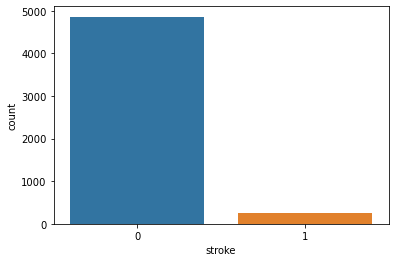

In [39]:
sns.countplot(df2.stroke);

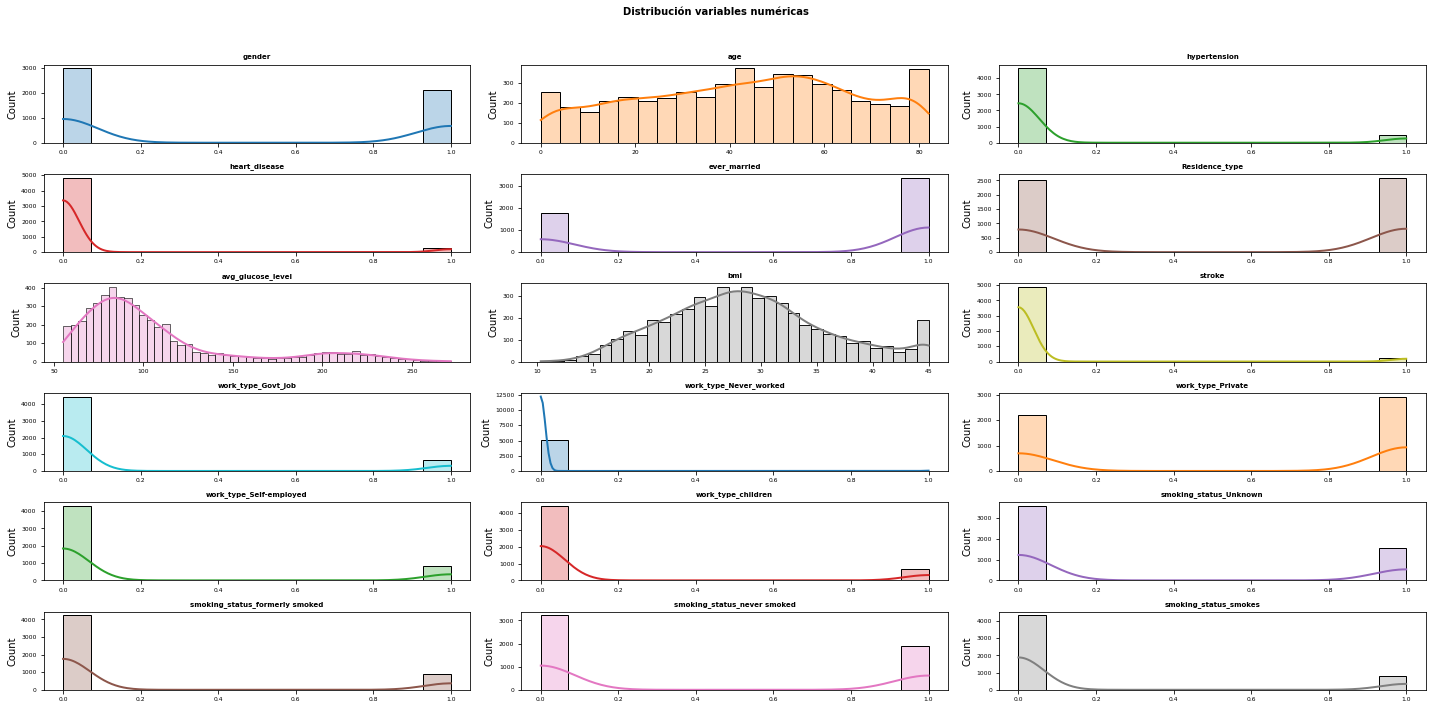

In [41]:
# DISTRIBUCION DE LAS VARIABLES

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(20, 10))
axes = axes.flat
columnas = df2.columns

for i, col in enumerate(columnas):
    sns.histplot(
        data    = df2,
        x       = col,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(col, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables', fontsize = 10, fontweight = "bold");

In [ ]:
# SCATTERPLOT CON AGE, HYPERTENSION, HEART DISEASE, GLUCOSE LEVEL

